### Load documents

In [1]:
from langchain_community.document_loaders import DirectoryLoader, Docx2txtLoader
from pathlib import Path
import glob

In [2]:
root_dir = Path('../').absolute()
root_dir

PosixPath('/home/ubuntu_wsl/gen_ai/rag_agent/notebooks/..')

In [3]:
doc_files = glob.glob(str(root_dir/'**/*.docx'))

doc_files

['/home/ubuntu_wsl/gen_ai/rag_agent/notebooks/../docs/3-bonus.docx',
 '/home/ubuntu_wsl/gen_ai/rag_agent/notebooks/../docs/2-deposit.docx',
 '/home/ubuntu_wsl/gen_ai/rag_agent/notebooks/../docs/4-games.docx',
 '/home/ubuntu_wsl/gen_ai/rag_agent/notebooks/../docs/1-account and website.docx',
 '/home/ubuntu_wsl/gen_ai/rag_agent/notebooks/../docs/5-issues.docx',
 '/home/ubuntu_wsl/gen_ai/rag_agent/notebooks/../docs/6-Genral.docx']

In [4]:
loader = Docx2txtLoader(doc_files[3])

data = loader.load()

data

[Document(metadata={'source': '/home/ubuntu_wsl/gen_ai/rag_agent/notebooks/../docs/1-account and website.docx'}, page_content='Hello, my name is Harry, I will be glad to help you!\n\nمرحبًا ، اسمي هاري ، سأكون سعيدًا بمساعدتك! \n\n\n\nWhat is this site? What is on here? Who are you?\n\nValorBet is a licensed online casino. Here you can place bets on slot machines, live dealer games, roulette, poker, and much more. We have games from over 2000 providers. Additionally, we have a high-level loyalty program, which means you don\'t need to verify your account to deposit or withdraw funds.\n\n\n\nIs this site safe?\n\nOur website operates under a license issued in Curaçao, and all our gaming machines and providers are official and undergo rigorous checks by independent entities. You can play with peace of mind, as your security is guaranteed.\n\n\n\nPlease provide me with the link to download your app\n\nCurrently, we do not have an official mobile app. If you previously used an app from our

In [5]:
loader = DirectoryLoader(
        path=root_dir/'docs',
        glob="**/*.docx",
        loader_cls=Docx2txtLoader,
        show_progress=True,
        use_multithreading=True
    )

In [6]:
documents = loader.load()
    
if not documents:
    print("No documents found in the 'docs' folder.")
else:
    print(f"Loaded {len(documents)} documents")

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 42.76it/s]

Loaded 6 documents


### Text Splitting

In [7]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [8]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    length_function=len,
    is_separator_regex=False,
)

splits = text_splitter.split_documents(documents)
print(f"Split into {len(splits)} chunks")

Split into 105 chunks


In [9]:
splits[0]

Document(metadata={'source': '/home/ubuntu_wsl/gen_ai/rag_agent/notebooks/../docs/3-bonus.docx'}, page_content='How can I view my bonus history?\n\nTo view your bonus history, please follow these steps: \n1. Go to the "Account" section. \n2. Click on the "Bonuses" tab. \n3. You will find all the bonuses you have used, organized into different sections.\n\n\n\nHow can I see my active bonuses?\n\nTo view your active bonuses, please follow these steps: \n\n1. Go to the "Accoun" section. \n\n2. Select the "Bonuses" category. \n\n3. Click on the "Active" option. You will see a list of all your current active bonuses.\n\n\n\nHow can I view the bonuses I\'ve already completed? I want to see the bonuses I\'ve met the wagering requirements for.\n\nTo see the bonuses for which you have met the wagering requirements, please follow these steps: 1. Go to the "Account" section. \n\n2. Select the "Bonuses" category. \n\n3. Click on the "Completed" tab. There, you will find a list of all bonuses that 

### Embedding and Vector store

In [10]:
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_chroma import Chroma

embedding_model = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2")

In [11]:
# 4. Create and persist ChromaDB vector store
vectorstore = Chroma.from_documents(
    documents=splits,
    embedding=embedding_model,
    persist_directory=str(root_dir/"vector_stores")  # directory to store the vector DB
)

print("Vector store created and persisted at 'vector_stores'")

Vector store created and persisted at 'vector_stores'


In [12]:
from langchain import hub

In [13]:
from langgraph.graph import START, StateGraph
from langchain_core.documents import Document
from typing_extensions import List, TypedDict
from langchain_ollama import ChatOllama

In [23]:
prompt = hub.pull("rlm/rag-prompt")


# llm = ChatOllama(
#     model="mistral",
#     temperature=0.7,
# )

llm = ChatOllama(
    model="deepseek-r1:1.5b",
    temperature=0.7,
)

# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    retrieved_docs = vectorstore.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

/home/ubuntu_wsl/gen_ai/rag_agent/venv/lib/python3.12/site-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [24]:
from IPython.display import Image, display

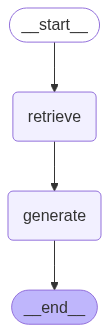

In [25]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
for step in graph.stream(
    {"question": "How to make a withdrawal?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='00d6a929-25ef-429d-b8ec-7e9bde40b5f3', metadata={'source': '/home/ubuntu_wsl/gen_ai/rag_agent/notebooks/../docs/2-deposit.docx'}, page_content="What is the withdrawal cancellation procedure?\n\nIt is not possible to cancel a withdrawal request. Withdrawals on our site are processed automatically. If you made a mistake when making the request, the payment will be rejected shortly.\n\n\n\nWhere's my loot? I requested the withdrawal and so far it has not been credited to my account.\n\nThe withdrawal period is from 15 minutes to 7 days, do not worry your withdrawal is being processed, we ask that you wait for this period in accordance with our payment system which is processing your withdrawal safely so that you can have all the comfort and security in play, remembering that after requesting a withdrawal, it is not recommended to place a bet if you wish to withdraw.\n\n\n\nWhy hasn't my withdrawal been credited yet?"), Document(id='04fc9dc6-a9d5-430f

In [19]:
for step in graph.stream(
    {"question": "retrieve all the greetings"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='8d5786bc-391e-4d85-8b2e-dcb45fd673e3', metadata={'source': '/home/ubuntu_wsl/gen_ai/rag_agent/notebooks/../docs/6-Genral.docx'}, page_content="Currently, there is no such a [...]\n\n\n\nSome delays or overloads of chats\n\nSorry for keeping you waiting! I need a few more minutes to check your request.\n\nI apologize for the delayed answer.\n\nThank you for your patience! It's highly appreciated.\n\nI am checking this information with my colleagues, kindly ask you to wait a bit.\n\n\n\nThe client is not answering\n\nAre we still in touch?\n\nIn case you want to get this bonus, drop me a line anytime. I will be here for you.\n\nOther\n\nThank you so much for your cooperation!\n\nWe are thrilled to be your top choice.\n\nI completely understand your feelings.\n\n\n\nFarewell/checkup/closure\n\nThank you for your understanding. Do you have any other questions?\n\nSure, I will gladly assist you next time too!\n\nMy pleasure! If you have any other quest